In [1]:
from data.byol_transform import *
import numpy as np
from model import BYOLModel
import yaml
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch import nn
from skimage.segmentation import slic
from torchvision.models._utils import IntermediateLayerGetter
from sklearn.cluster import *

In [2]:

anno = '/home/jacklishufan/ByteTrack/datasets/coco/annotations/instances_train2017.json'
image_dir="/home/jacklishufan/detconb/imagenet"
root = '/home/jacklishufan/ByteTrack/datasets/coco/train2017'
stage = 'train'
mask_type = 'fh'
transform1 = get_transform(stage)
transform2 = get_transform(stage, gb_prob=0.1, solarize_prob=0.2)
transform3 = get_transform('raw')
transform = MultiViewDataInjector([transform1, transform2,transform3],False)
image_dir_t = os.path.join(image_dir,'images', f"{'train' if stage in ('train', 'ft') else 'val'}")
mask_file = os.path.join(image_dir,'masks',stage+'_tf_img_to_'+mask_type+'.pkl')
mask_file_path = os.path.join(image_dir,'masks','train_tf')
dataset = SSLMaskDataset(image_dir_t,mask_file,transform=transform,mask_file_path=mask_file_path)

total files: 12811


In [3]:
japanese = '/shared/jacklishufan/04_24_17-51_resnet50_300.pth.tar'
coco = '/shared/jacklishufan/ckpt-4-26/detconb/04_25_16-13/04_25_16-13_resnet50_30.pth.tar'
mp = 'ckpt/detconb/04_27_14-27/04_27_14-27_resnet50_300.pth.tar'

In [4]:
torch.cuda.set_device(8)

device='cuda:8'
with open('/home/jacklishufan/detconb/config/train_imagenet_300_detcol.yaml') as f:
    config = yaml.safe_load(f)
config['rank']=0
model = BYOLModel(config)

state = torch.load(mp,map_location='cpu')
new_model = {}
for k,v in state['model'].items():
    if 'module' not in k or 'fpn' in k:
        continue
    new_model[k.replace('module.','')] = v
model.load_state_dict(new_model)

FileNotFoundError: [Errno 2] No such file or directory: 'ckpt/detconb/04_27_14-27/04_27_14-27_resnet50_300.pth.tar'

In [31]:
state = torch.load(coco,map_location='cpu')
new_model = {}
for k,v in state['model'].items():
    prefix = 'module.online_network.encoder.'
    if prefix not in k or 'fpn' in k:
        continue
    new_model[k.replace(prefix,'')] = v

In [32]:
model.online_network.encoder.load_state_dict(new_model)

<All keys matched successfully>

In [5]:
model.to(device)
model.eval()

BYOLModel(
  (online_network): EncoderwithProjection(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [6]:
def to_slic(img,**kwargs):
    img = img.permute(1, 2, 0)
    h, w, c = img.size()
    seg = slic(img.to(torch.double).numpy(), start_label=0, **kwargs)
    seg = torch.from_numpy(seg)
    return seg.view(1, h, w)

In [7]:
def plot_image(ax,x):
    ax.imshow(np.exp(x.permute(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


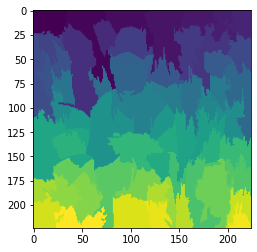

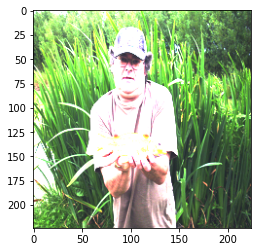

In [8]:

plt.imshow(mask[2,1])
plt.figure()
plot_image(plt,view_raw)

In [37]:
def cosine_attention(pixels,ref_vec):
    '''
    ref_vec: B X dim_emb
    pixels: B X H X W X dim_emb
    '''
    ref_vec = F.normalize(ref_vec,dim=-1)
    pixels = F.normalize(pixels,dim=1)
    atten = torch.einsum('bcxy,bc->bxy',pixels,ref_vec)
    return atten

In [125]:
def cosine_attention2(pixels,ref_vec):
    '''
    ref_vec: B X dim_emb
    pixels: B X H X W X dim_emb
    '''
    ref_vec = F.normalize(ref_vec,dim=1)
    pixels = F.normalize(pixels,dim=1)
    atten = torch.einsum('bcxy,bcij->bxyij',pixels,ref_vec)
    return atten

In [39]:
emb_1.shape

torch.Size([1, 2048, 7, 7])

In [40]:
atten_ab == atten_aa

tensor([[[False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False]]])

In [41]:
atten_aa

tensor([[[0.6371, 0.5671, 0.6483, 0.7003, 0.6595, 0.6554, 0.6382],
         [0.6852, 0.6178, 0.6370, 0.7092, 0.6425, 0.6421, 0.6436],
         [0.6857, 0.6866, 0.6708, 0.6779, 0.6686, 0.6296, 0.6798],
         [0.6741, 0.6966, 0.6902, 0.6749, 0.5981, 0.6589, 0.6696],
         [0.6792, 0.6753, 0.6634, 0.6810, 0.6527, 0.6616, 0.6658],
         [0.6398, 0.6620, 0.6384, 0.6416, 0.6710, 0.6219, 0.5954],
         [0.5988, 0.6246, 0.6628, 0.6249, 0.6017, 0.6261, 0.5608]]])

In [126]:
with torch.no_grad():
    emb_1 = model.online_network.encoder(view1.unsqueeze(0).cuda())
    emb_2 = model.online_network.encoder(view2.unsqueeze(0).cuda())
    emb_3 = model.online_network.encoder(view_raw.unsqueeze(0).cuda())
    emb_1_bar = emb_1.mean((-1,-2))
    emb_2_bar = emb_2.mean((-1,-2))
    atten_ab = cosine_attention(emb_1,emb_2_bar).detach().cpu()
    atten_ba = cosine_attention(emb_2,emb_1_bar).detach().cpu()
    atten_aa = cosine_attention(emb_1,emb_1_bar).detach().cpu()
    atten_bb = cosine_attention(emb_2,emb_2_bar).detach().cpu()
    atten_aaaa = cosine_attention2(emb_1,emb_1).detach().cpu()

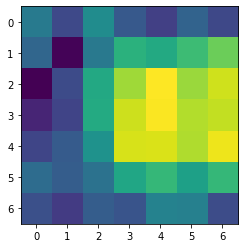

In [151]:
atten_aaaa.reshape(1,7,7,-1).sum(-1).shape

torch.Size([1, 7, 7])

In [137]:
atten_aaaa.reshape(1,7,7,-1).shape

torch.Size([1, 7, 7, 49])

In [135]:
 100//7 ,100 %7

(14, 2)

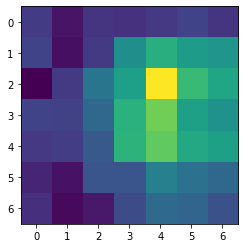

In [92]:
model.online_network.encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [93]:
extractor = IntermediateLayerGetter(model.online_network.encoder, return_layers={'7':'out','6':'c4','5':'c3'})

In [191]:
f = lambda x:extractor(x)['c4']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


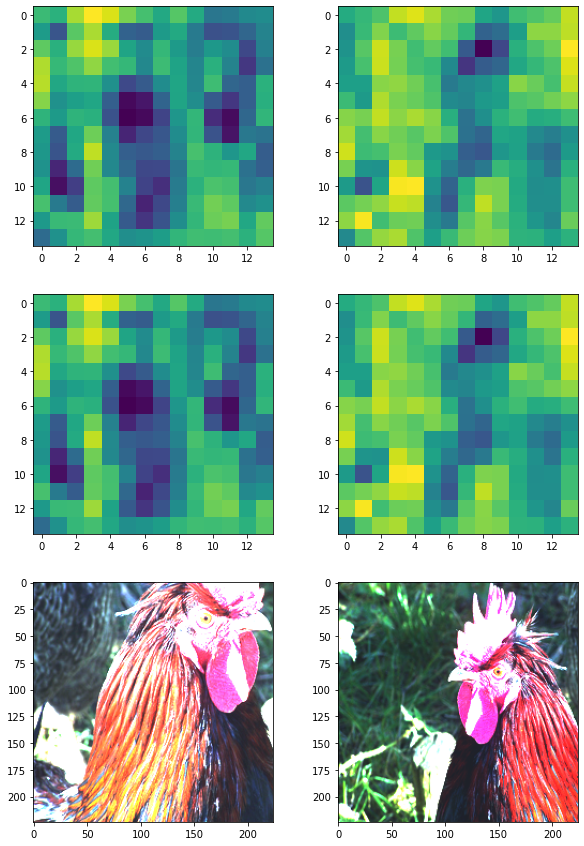

In [192]:
image,mask,transform = dataset[100]
view1,view2,view_raw = image
with torch.no_grad():
    emb_1 = f(view1.unsqueeze(0).cuda())
    emb_2 = f(view2.unsqueeze(0).cuda())
    emb_3 = f(view_raw.unsqueeze(0).cuda())
    emb_1_bar = emb_3.mean((-1,-2))
    emb_2_bar = emb_3.mean((-1,-2))
    atten_ab = cosine_attention(emb_1,emb_2_bar).detach().cpu()
    atten_ba = cosine_attention(emb_2,emb_1_bar).detach().cpu()
    atten_aa = cosine_attention(emb_1,emb_1_bar).detach().cpu()
    atten_bb = cosine_attention(emb_2,emb_2_bar).detach().cpu()
    atten_aaaa = cosine_attention2(emb_1,emb_1).detach().cpu()

fig,ax = plt.subplots(3,2,figsize=(10,15))
ax[0][0].imshow(atten_aa[0])
ax[0][1].imshow(atten_ba[0])
ax[1][0].imshow(atten_ab[0])
ax[1][1].imshow(atten_bb[0])
plot_image(ax[2][0],view1)
plot_image(ax[2][1],view2)

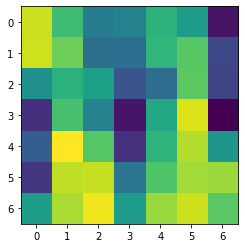

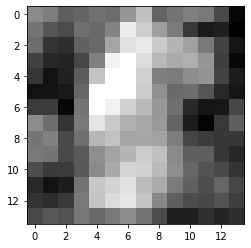

In [194]:
plt.imshow((atten_aaaa.reshape(1,7,7,-1).sum(-1))[0])
plt.figure()
plt.imshow(atten_aaaa[0][4][5],cmap='gray',vmax=0.75)

In [183]:
atten_aaaa

tensor([[[[[1.0000, 0.6956, 0.6307,  ..., 0.6554, 0.6508, 0.7009],
           [0.7260, 0.5112, 0.3822,  ..., 0.3855, 0.4618, 0.5359],
           [0.5674, 0.3818, 0.4508,  ..., 0.2839, 0.2918, 0.3702],
           ...,
           [0.5338, 0.3943, 0.3100,  ..., 0.4699, 0.4210, 0.4673],
           [0.5534, 0.2818, 0.3719,  ..., 0.3617, 0.3699, 0.3712],
           [0.5484, 0.3840, 0.3943,  ..., 0.2941, 0.3277, 0.4578]],

          [[0.6956, 1.0000, 0.6753,  ..., 0.6751, 0.7213, 0.5634],
           [0.5440, 0.6424, 0.4433,  ..., 0.4034, 0.5157, 0.5586],
           [0.5093, 0.4936, 0.4856,  ..., 0.3449, 0.3639, 0.3531],
           ...,
           [0.4658, 0.5403, 0.3816,  ..., 0.5195, 0.4585, 0.3887],
           [0.4415, 0.3730, 0.4126,  ..., 0.3902, 0.4846, 0.3256],
           [0.3825, 0.4711, 0.3890,  ..., 0.2789, 0.2880, 0.4055]],

          [[0.6307, 0.6753, 1.0000,  ..., 0.5644, 0.7378, 0.6595],
           [0.4732, 0.5365, 0.5530,  ..., 0.4349, 0.5077, 0.4823],
           [0.4741, 0.5289

In [174]:
b,c,h,w = emb_3.shape
data = emb_3.detach().cpu().permute(2,3,1,0).reshape(-1,c)
agg = AgglomerativeClustering(affinity='cosine',linkage='average',distance_threshold=0.2,n_clusters=None).fit(data)
agg = MiniBatchKMeans(n_clusters=5).fit(data)

In [175]:
#(agg.labels_).reshape(7,7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


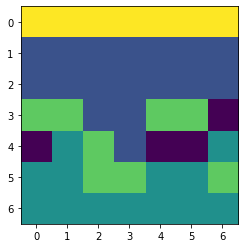

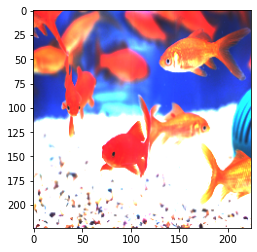

In [176]:
plt.imshow((agg.labels_).reshape(h,w))
plt.figure()
plot_image(plt,view_raw)

In [45]:
emb_1.shape

torch.Size([1, 2048, 7, 7])

In [16]:
emb_1_bar.shape

torch.Size([1, 2048])

In [58]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering,KMeans


In [8]:
encoder = model.online_network.encoder

In [137]:
mask[2,1:].shape

torch.Size([1, 224, 224])

In [143]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [152]:
np.stack([[1],[2]]).shape

AttributeError: module 'numpy' has no attribute 'cat'

In [147]:
np.max(agg.labels_)

3

In [146]:
image,mask,transform = dataset[12]
feats = model.fpn(view_raw.unsqueeze(0).cuda())['c4']
feats_flatten = feats.detach().cpu().T.reshape(-1,1024)
masks = model.masknet(feats.detach()).detach().cpu()
masks = F.normalize(masks,1)
data = masks.permute(2,3,1,0).reshape(-1,32)
view1,view2,view_raw = image
agg = AgglomerativeClustering(affinity='cosine',linkage='average',distance_threshold=0.2,n_clusters=None).fit(data)
agg2 = AgglomerativeClustering(affinity='cosine',linkage='average',distance_threshold=0.2,n_clusters=None).fit(feats_flatten)
#agg2 = KMeans(n_clusters=16).fit(feats_flatten)
plt.figure()
plt.imshow(agg.labels_.reshape(14,14))
plt.figure()
plt.imshow(agg2.labels_.reshape(14,14))
plt.figure()
plot_image(plt,view_raw)
plt.figure()
masks = masks.argmax(1)
plt.imshow(masks[0])

ValueError: Exactly one of n_clusters and distance_threshold has to be set, and the other needs to be None.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


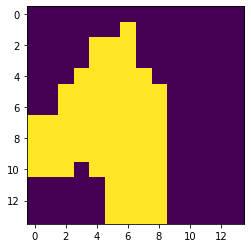

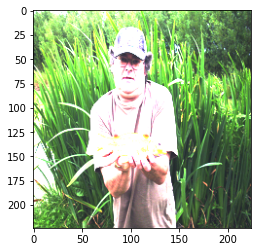

NameError: name 'encoder' is not defined

In [12]:
extractor.eval()
extractor.cuda()
feats = extractor(view_raw.unsqueeze(0).cuda())

In [13]:
c_4_out = feats['c4']
c_5_out = feats['out']

In [14]:
c_5_out.shape

torch.Size([1, 2048, 7, 7])

In [121]:
c_4_upsampled = F.interpolate(c_5_out,(14,14)).shape

In [16]:
c_4_out_flatten = c_4_out.detach().cpu().permute(0,2,3,1).reshape(-1,1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


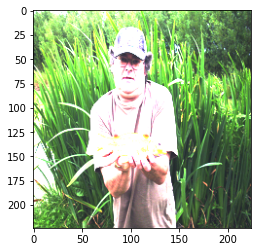

In [17]:
plot_image(plt,view_raw)

In [18]:
# F.interpolate(view_raw,(14,14))

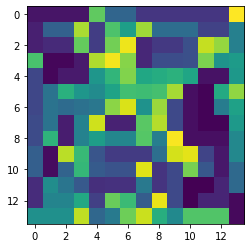

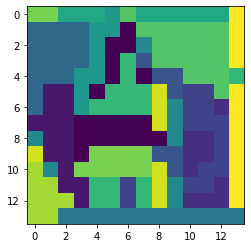

In [19]:
kmeans = KMeans(n_clusters=16, random_state=0).fit(c_4_out_flatten)
agg = AgglomerativeClustering(affinity='cosine',linkage='average',distance_threshold=0.2,n_clusters=None).fit(c_4_out_flatten)
plt.imshow(agg.labels_.reshape(14,14))
plt.figure()
plt.imshow(kmeans.labels_.reshape(14,14))

In [134]:
def to_binary_mask(label_map,c_m,resize_to=None):
    b,h,w = label_map.shape
    label_map_one_hot = F.one_hot(label_map,c_m).permute(0,3,1,2).float()
    if resize_to is not None:
        label_map_one_hot = F.interpolate(label_map_one_hot,resize_to, mode='bilinear',align_corners=False)
        label_map = torch.argmax(label_map_one_hot,1)
        h,w = resize_to
    label_map_one_hot = label_map_one_hot.reshape(b,c_m,h*w)
    return label_map_one_hot.view(b,c_m,h,w)

In [135]:
def refine_mask(src_label,target_label,mask_dim):
        # B X H_mask X W_mask
        n_tgt = torch.max(target_label).item()+1
        slic_mask = to_binary_mask(target_label,n_tgt,(mask_dim,mask_dim))  # B X 100 X H_mask X W_mask
        masknet_label_map = to_binary_mask(src_label,16,(mask_dim,mask_dim)) # binary B X 16 X H_mask X W_mask
        pooled,_ =maskpool(slic_mask,masknet_label_map) # B X NUM_SLIC X N_MASKS
        pooled_ids = torch.argmax(pooled,-1) # B X NUM_SLIC  X 1 => label map
        converted_idx = torch.einsum('bchw,bc->bchw',slic_mask ,pooled_ids).sum(1).long().detach() #label map in hw space
        return converted_idx
def maskpool(mask,x):
    '''
    mask: B X C_M X  H X W (1 hot encoding of mask)
    x: B X C X H X W (normal mask)
    '''
    _,c_m,_,_ = mask.shape
    b,c,h,w = x.shape
    mask = mask.view(b,c_m,h*w)
    mask_area = mask.sum(dim=-1,keepdims=True)
    mask = mask / torch.maximum(mask_area, torch.ones_like(mask))
    x = x.permute(0,2,3,1).reshape(b,h*w,c) # B X HW X C
    x = torch.matmul(mask.view(b,c_m,h*w), x)
    return x,mask

In [22]:
class SpatialAttentionBlock(nn.Module):

    def __init__(self,in_dim=2048,atten_dim=64,emb_dim=64):
        super().__init__()
        self.k_map = nn.Conv2d(in_dim,atten_dim,1)
        self.q_map = nn.Conv2d(in_dim,atten_dim,1)
        self.v_map = nn.Conv2d(in_dim,emb_dim,1)
        self.atten_dim = atten_dim

    def forward(self, x):
        #B X C X (H X W)
        b,_,h,w = x.shape
        q = self.q_map(x)   # B X atten_dim X (H X W) 
        k = self.k_map(x)   # B X atten_dim X (H X W) 
        v = self.v_map(x)   # B X emb_dim X (H X W) 
        atten =torch.einsum('bcxy,bcij->bxyij',q,k) # B X (H X W) X( H X W)
        atten /= self.atten_dim
        atten = atten.reshape(b,h,w,h*w)
        atten = F.softmax(atten,dim=-1)
        atten = atten.reshape(b,h,w,h,w)
        out = torch.einsum('bxyij,bdij->bxyd',atten,v) # B X( H X W) X d_emb
        return out.permute(0,3,1,2)
    
class FCNMaskNet(nn.Module):
    '''
      (decode_head): FCNHead(
    input_transform=None, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss()
    (conv_seg): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
    (dropout): Dropout2d(p=0.1, inplace=False)
    (convs): Sequential(
      (0): ConvModule(
        (conv): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
        (bn): SyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): ReLU(inplace=True)
      )
      (1): ConvModule(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
        (bn): SyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): ReLU(inplace=True)
      )
    )
    (conv_cat): ConvModule(
      (conv): Conv2d(2304, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): SyncBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
  )
    '''
    def __init__(self,attention=False,upsample=56):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.conv2 =  nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.convSeg = nn.Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
        self.dropout = nn.Dropout2d(p=0.1, inplace=False)
        #self.softmax = nn.Softmax2d()
        self.finalbn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        self.attention = attention
        if self.attention:
            self.atten = SpatialAttentionBlock(256,64,256)
            self.conv3 = nn.Conv2d(256, 256, 1, bias=False)
            
        self.upsample = upsample
        
    def forward(self, x):
        #7x7x2048
        #TODO: RESAMPLE ATTENTION
        upsample = self.upsample
        if self.attention:
            x_norm = F.interpolate(x, (upsample,upsample), mode='bilinear',align_corners=False)
            x_norm = F.normalize(x_norm,dim=1)
            atten =torch.einsum('bcxy,bcij->bxyij',x_norm,x_norm) #B X H X W X H X W
        x = self.conv1(x)
        x = F.interpolate(x, (upsample,upsample), mode='bilinear',align_corners=False)
        x = self.conv2(x)
        x = self.dropout(x)
        # 
        if self.attention:
            #x = self.atten(x)+self.conv3(x)
            #print(x.shape,atten.shape,self.conv3(x).shape)
            x = torch.einsum('bxyij,bdij->bxyd',atten,x).permute(0,3,1,2) #+self.conv3(x)# B X( H X W) X d_emb, # Similar matrice will have simlar embeding
        x = self.finalbn(x)
        x = self.convSeg(x)
        #x = self.finalbn(x)
        
        #x = self.softmax(x)
        #breakpoint()
        # x = self.atten(x) +self.conv3(x)
        # x = F.softmax(x,dim=1) # B X C X H X W
        return x

In [23]:
masknet = FCNMaskNet(attention=False)
masknet.to(device)

FCNMaskNet(
  (conv1): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convSeg): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (finalbn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [24]:
data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        sampler=None,
        drop_last=True
)

In [25]:
from optimizer import LARS

In [26]:
from utils.data_prefetcher import data_prefetcher

In [27]:
extractor.cuda()

IntermediateLayerGetter(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


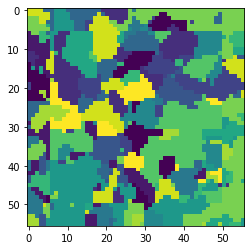

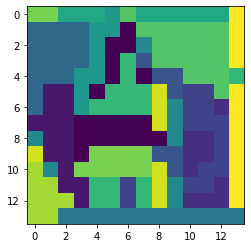

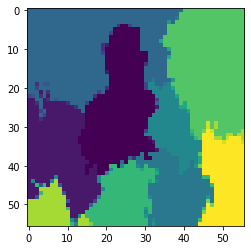

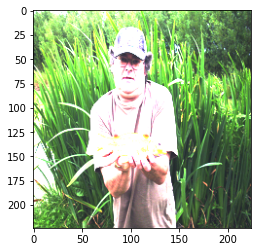

In [28]:
image,mask,transform = dataset[4]
view1,view2,view_raw = image
feats = extractor(view_raw.unsqueeze(0).cuda())['c4'].cuda()
masknet.train()
mask = masknet(feats)
label_map = torch.argmax(mask,1).detach()
src = label_map
src = torch.LongTensor(kmeans.labels_.reshape(1,14,14)).cuda()
tgt = to_slic(view_raw,n_segments=24).cuda()
converted_idx = refine_mask(src,tgt,56)
kmeans = KMeans(n_clusters=16, random_state=0).fit(feats[0].flatten(-2,-1).detach().T.cpu())
plt.imshow(torch.argmax(mask,1)[0].detach().cpu())
plt.figure()
plt.imshow(kmeans.labels_.reshape(14,14))
plt.figure()
plt.imshow(converted_idx[0].detach().cpu())
plt.figure()
plot_image(plt,view_raw)

In [29]:
tgt = to_slic(view_raw,n_segments=100).cuda()


In [30]:
view_raw.shape

torch.Size([3, 224, 224])

In [31]:
kmeans_label = kmeans.labels_.reshape(1,14,14)

In [37]:
super_pixel = to_binary_mask(tgt,100,resize_to=(14,14))
pooled, _ = maskpool(super_pixel,feats)

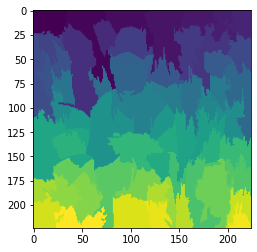

In [35]:
plt.imshow(tgt[0].detach().cpu())

In [40]:
super_pixel_pooled = pooled.detach().cpu().numpy().reshape(-1,1024)

In [109]:
kmeans_superpixel = KMeans(n_clusters=5, random_state=0).fit(super_pixel_pooled)

In [122]:
label_map = kmeans_superpixel.labels_.reshape(1,-1)

In [111]:
#super_pixel

In [123]:
converted_idx = torch.einsum('bchw,bc->bchw',to_binary_mask(tgt,100,(56,56)) ,torch.LongTensor(label_map).cuda()).sum(1).long().detach()

In [124]:
cc = converted_idx[0].detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


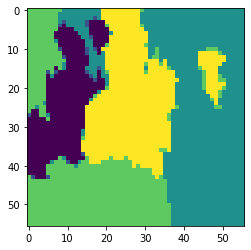

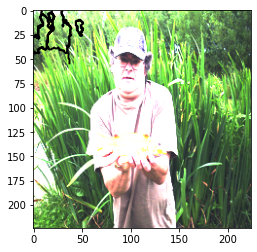

In [125]:
plt.imshow(cc)
plt.figure()
plot_image(plt,view_raw)
plt.contour(cc,colors='black')

In [74]:
pooled.detach().cpu().numpy().reshape(-1,1024)[22]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [37]:
feats[0].flatten(-2,-1).detach().cpu().shape

torch.Size([1024, 196])

In [38]:
feats[0].flatten(-2,-1).T

tensor([[0.0000, 7.2914, 0.0000,  ..., 1.7933, 3.8596, 3.0439],
        [0.0000, 6.7509, 0.0000,  ..., 1.1695, 5.4171, 1.2390],
        [0.0000, 6.6864, 0.1131,  ..., 1.4243, 3.2630, 0.0000],
        ...,
        [2.9882, 0.0236, 0.6296,  ..., 0.0000, 1.4547, 2.2618],
        [1.5770, 0.2706, 0.3875,  ..., 0.0000, 1.9870, 2.5125],
        [0.9288, 0.7069, 0.5078,  ..., 1.2121, 1.9497, 2.7985]],
       device='cuda:8', grad_fn=<PermuteBackward0>)

In [70]:
np.sqrt(1024)

32.0

In [66]:
feats.shape

torch.Size([1, 1024, 14, 14])

In [96]:
masknet = FCNMaskNet(attention=False)
masknet.to(device)
extractor.to(device)
print("DONE")

DONE


In [ ]:
optimizer = LARS(masknet.parameters(), lr=0.1, momentum=0.9 , weight_decay=1e-6)
loss_func = nn.CrossEntropyLoss()
for epoch in range(50):
    prefetcher = data_prefetcher(data_loader)
    iter_ = 0
    image,raw_mask,transform = prefetcher.next()
    while image is not None:
        # B X 3 X C X H X W
        view_raw = image[:,2,...].cuda()
        c_4_out = extractor(view_raw)['c4']
        mask = masknet(c_4_out.to(device))
        label_map = torch.argmax(mask,1).detach()
        src = label_map
        tgt = raw_mask[:,2,1].cuda()
        converted_idx = refine_mask(src,tgt,56)
        loss = loss_func(mask,converted_idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if iter_ % 50 ==0:
            print(iter_,loss)
        iter_ +=1
        image,raw_mask,transform = prefetcher.next()

0 tensor(2.3484, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
50 tensor(0.8516, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
100 tensor(0.6758, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
150 tensor(0.7188, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
200 tensor(0.5553, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
250 tensor(0.5924, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
300 tensor(0.4345, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
350 tensor(0.3721, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
0 tensor(0.4247, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
50 tensor(0.4381, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
100 tensor(0.4009, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
150 tensor(0.3742, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
200 tensor(0.3632, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
250 tensor(0.3331, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
300 tensor(0.4403, device='cuda:8', grad_fn=<NllLoss2DBackward0>)
350 tensor(0.248

In [ ]:
img.shape

In [ ]:
raw_mask[:,2,1].shape

In [ ]:
converted_idx()

In [ ]:
plt.imshow(torch.argmax(mask,1)[0].detach().cpu())
plt.figure()
plt.imshow(converted_idx[0])

In [ ]:
kmeans = KMeans(n_clusters=16, random_state=0).fit(c_4_out_flatten)
src = torch.LongTensor(kmeans.labels_.reshape(14,14)).unsqueeze(0)
tgt = to_slic(view_raw,n_segments=30).cpu()
converted_idx = refine_mask(src,tgt,224)

In [ ]:
plot_image(plt,view_raw)
plt.contour(converted_idx[0],colors='black')
plt.figure()
plt.imshow(converted_idx[0])
plt.figure()
plt.imshow(kmeans.labels_.reshape(14,14))

In [ ]:

plot_image(plt,view_raw)
plt.contour((to_slic(view_raw,n_segments=100))[0],levels=1000,colors='black')